In [11]:
import cv2
import random
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

from IPython.display import display

In [12]:
imagesDirectory = '../data/images/'

In [13]:
exampleIDs = """SFF_D_1013
zbz-990054280370205508
zbz-990054295100205508
nb-1003704
SFF_D_1578
nb-1001087
SFF_D_1376
SFF_D_1404.002""".split("\n")

In [14]:
exampleImages = [join(imagesDirectory,d + '.jpg') for d in exampleIDs]

In [15]:
images = [cv2.imread(d) for d in exampleImages]
images = [image[:,:,::-1] for image in images]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image is bright
(24, 35, 754, 579)
Image is dark


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0, 17, 710, 1126)
Image is dark
(8, 3, 1014, 600)
Image is dark


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(18, 0, 978, 673)
Image is bright
(106, 94, 708, 507)
Image is bright


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(828, 717, 74, 67)
Image is bright


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(304, 466, 300, 485)
Image is bright
(817, 40, 174, 589)


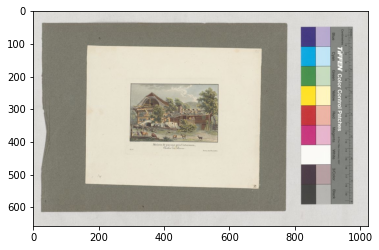

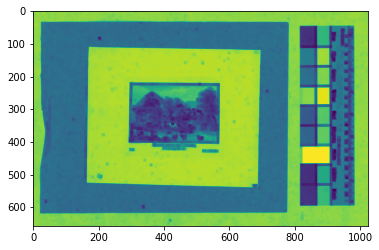

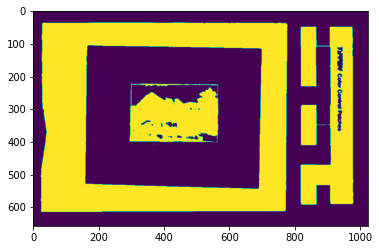

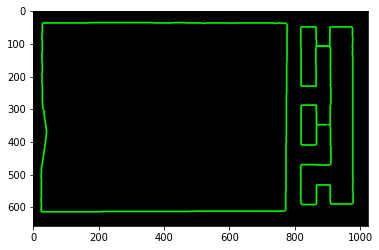

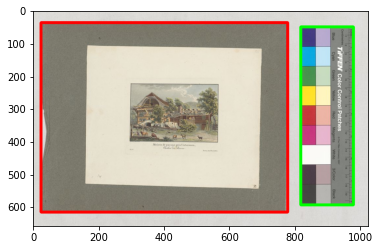

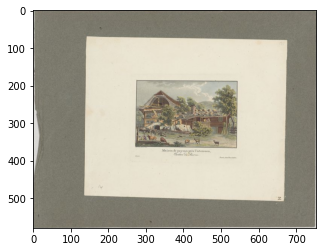

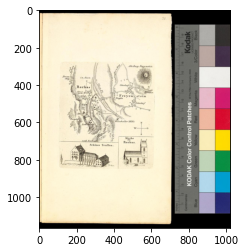

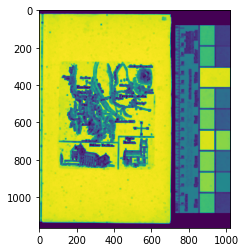

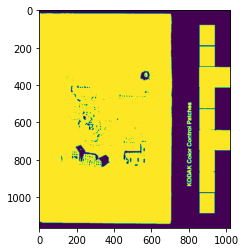

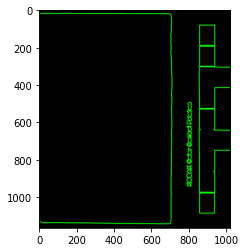

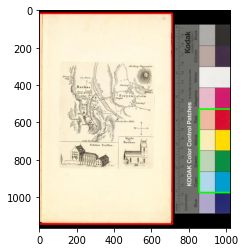

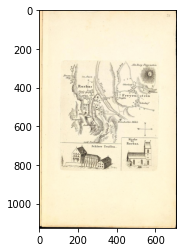

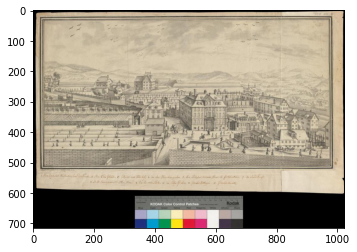

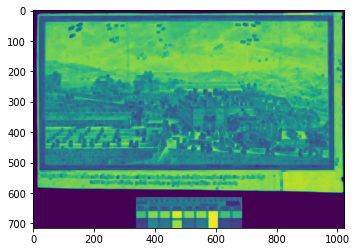

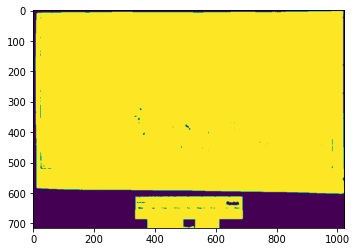

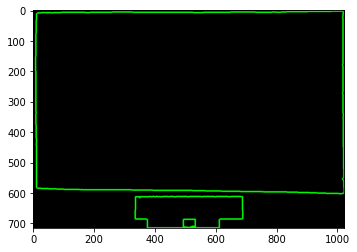

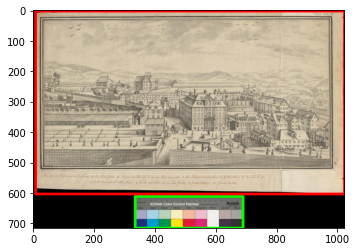

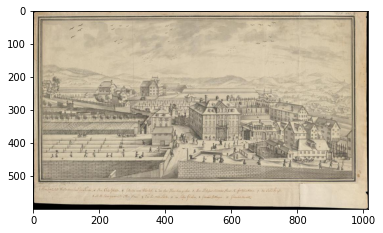

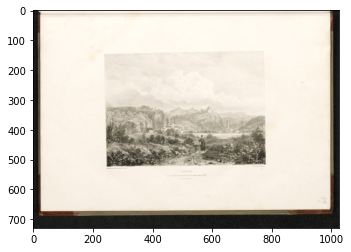

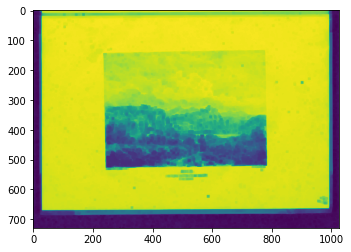

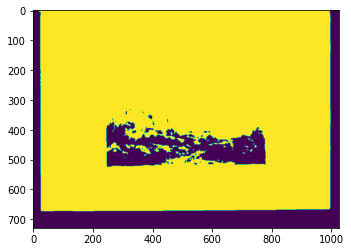

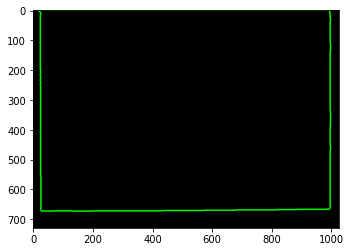

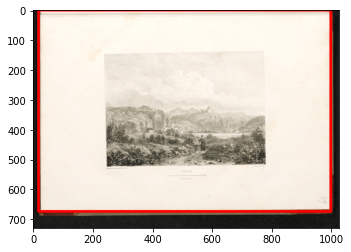

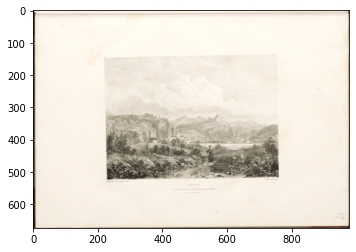

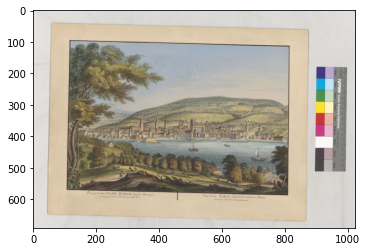

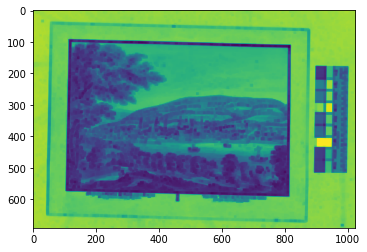

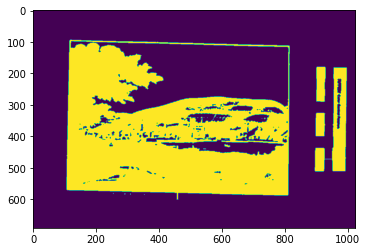

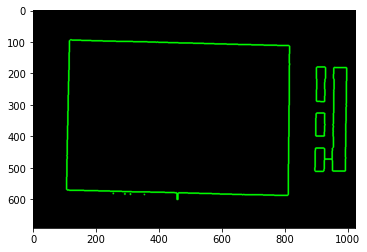

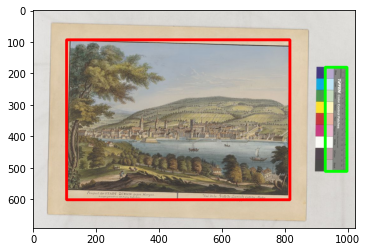

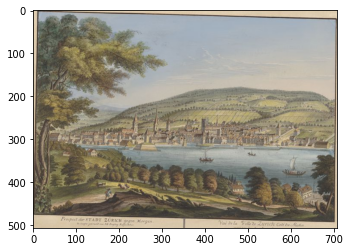

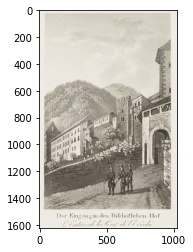

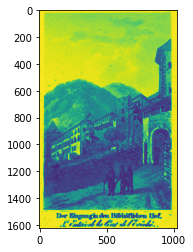

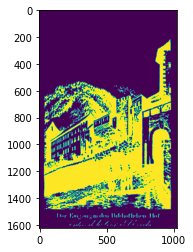

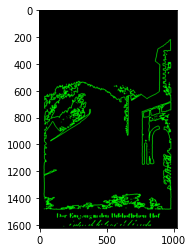

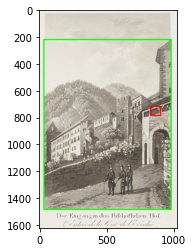

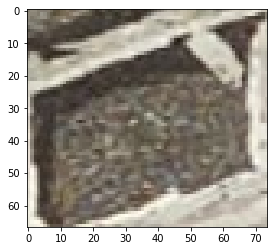

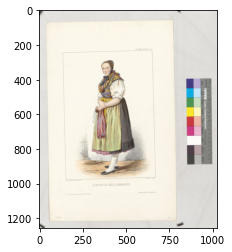

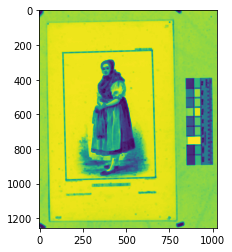

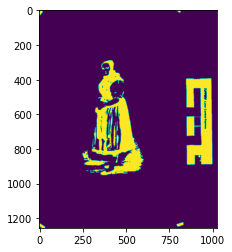

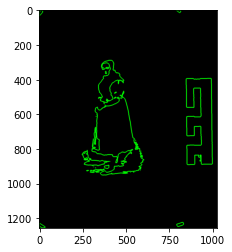

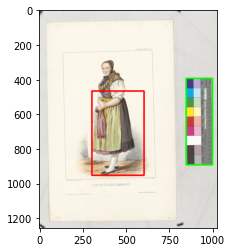

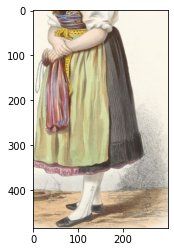

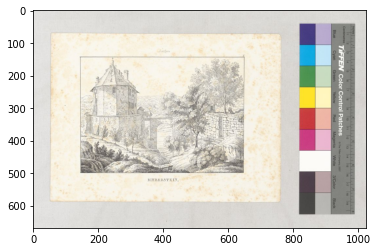

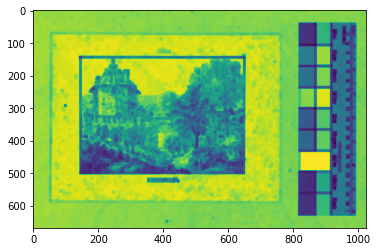

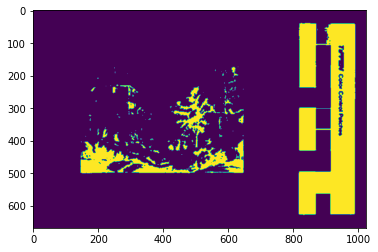

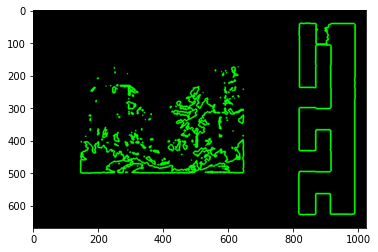

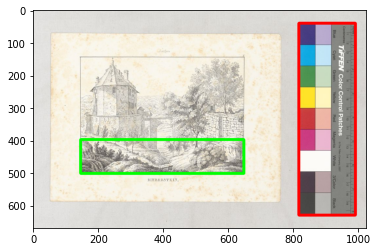

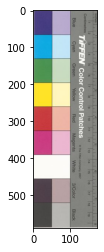

In [55]:
from matplotlib import pyplot as plt

class BSOImageCropping:
    
    showImages = False
    
    METHOD_TRHESH = 0
    METHOD_CANNY = 1
    
    def __init__(self, showImages=False):
        self.showImages = showImages
    
    def blurImage(self, image, amount=5):
        return cv2.blur(image.copy(), (amount, amount))
    
    def cannyImage(self, image):
        return cv2.Canny(image.copy(), 10, 20)
    
    def displayImage(self, image):
        plt.figure()
        plt.imshow(image)
        
    def erodeImage(self, image, iterations=3):
        kernel = np.ones((8,8),np.uint8)
        return cv2.erode(image.copy(), kernel, iterations)
        
    def extendImage(self, image):
        return cv2.copyMakeBorder(image.copy(), self.extension, self.extension, self.extension, self.extension, cv2.BORDER_REPLICATE)
    
    def makeBW(self, image):
        return cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
        
    def thresholdImage(self, image):   
        padding = 5
        if image[padding][image.shape[1]-padding] > 127:
            thresholdMethod = cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
            print("Image is bright")
        else:
            thresholdMethod = cv2.THRESH_BINARY+cv2.THRESH_OTSU
            print("Image is dark")
        
        ret, thresh = cv2.threshold(image,0,255,thresholdMethod)   
        return thresh
    
    def cropImage(self, image, preprocessMethod=METHOD_TRHESH):        
        grayImage = self.makeBW(image)
        erodedImage = self.erodeImage(grayImage)
        blurImage = self.blurImage(grayImage)
        
        if preprocessMethod == self.METHOD_CANNY:
            thresh = self.cannyImage(blurImage)
        else:
            thresh = self.thresholdImage(blurImage)
        
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        contourImage = np.zeros(image.shape)
        cv2.drawContours(contourImage, contours, -1, (0,255,0), 3)
            
        areas = [cv2.contourArea(c) for c in contours]
        indicesOfTwoLargestContours = [areas.index(x) for x in sorted(areas, reverse=True)[:2]]
        
        ratios = []
        for i in indicesOfTwoLargestContours:
            x,y,w,h = cv2.boundingRect(contours[i])
            ratios.append(max(w,h)/min(w,h))
        min_ratio_index = np.argmin(ratios)
        
        drawThickness = 8
        
        rectangleImage = image.copy()#np.zeros(image.shape)
        for i in indicesOfTwoLargestContours:
            x,y,w,h = cv2.boundingRect(contours[i])
            cv2.rectangle(rectangleImage, (x, y) , (x + w, y + h), (0,255,0) ,drawThickness)
        
        chosenX, chosenY, chosenW, chosenH = cv2.boundingRect(contours[indicesOfTwoLargestContours[min_ratio_index]])
        cv2.rectangle(rectangleImage, (chosenX, chosenY), (chosenX + chosenW, chosenY + chosenH), (255,0,0), drawThickness)

        croppedImage = image.copy()[chosenY:chosenY+chosenH, chosenX:chosenX+chosenW]
        
        if self.showImages:
            self.displayImage(image)
            self.displayImage(erodedImage)
            self.displayImage(thresh)
            self.displayImage(contourImage)
            self.displayImage(rectangleImage)
            self.displayImage(croppedImage)
            
        return chosenX, chosenY, chosenW, chosenH
            
            
detector = BSOImageCropping(showImages=True)
        
for image in images:#[6:]:
    print(detector.cropImage(image))
    
    